# Testing corrections

This is an example using eHDA data taken at APS. Here is demostrated how to do:
* Background substraction
* Polarization correction 
* Solid angle corrections

### Initialise

In [21]:
# -- import packages
import matplotlib.pyplot as plt
import numpy as np
import sys
import tifffile as tf

# -- import source files
sys.path.insert(0, '../scripts/')
from integrators import*
from utilities import *
from corrections import *

load files

In [22]:
CeO2       = np.array(tf.imread('../data/CeO2_test_0p1s10f-00032.tif'))
background = np.array(tf.imread('../data/eHDA007_1s120f_299.331-00530.tif'))
ehda       = np.array(tf.imread('../data/eHDA007_1s120f_82.071-00256.tif'))

parameters

In [23]:
# beam center (You can estimate this with fit2D or with the ring fitting script)
cx,cy = 1037,1031 

# ploting parameters
dx,dy = 150,150
vmin,vmax = 0,5e5

# angular integration parameters
n_bins = 3500           # number of bins
min_x,max_x = 0,760     #n_bins
mask_thr = 0            # threshold limit for integrator
qmax = 2.               # for the first peak 

# corrections parameters
pxd = 200*1e-6          #pixel size [m]
L   = 348*1e-3          #sample to detector disctance [m]
polfac = 1              #polarization factor (percent of horizontal polarization)
wlen = 0.1235           # wavelength x-ray [A]

Q calibration

In [16]:
# angular intergation
qbin,Iq = angular_average(CeO2, (cx,cy),None,threshold=mask_thr, nx=n_bins,  min_x=min_x, max_x=max_x)

# Q calibration 
Imax = max(Iq)
qbin_max = qbin[Iq==Imax]
q = qbin*(qmax/qbin_max)

### Background subtraction

In [17]:
# ring mask
inner_radius,width,spacing,num_rings=15,15,0,1
mask = ring_mask(ehda,(cx,cy),inner_radius=inner_radius,width=width,spacing=spacing,num_rings=num_rings)

dx,dy = 30,30
norm = np.sum(ehda*mask)/np.sum(background*mask)
ehda2 = ehda-background*norm

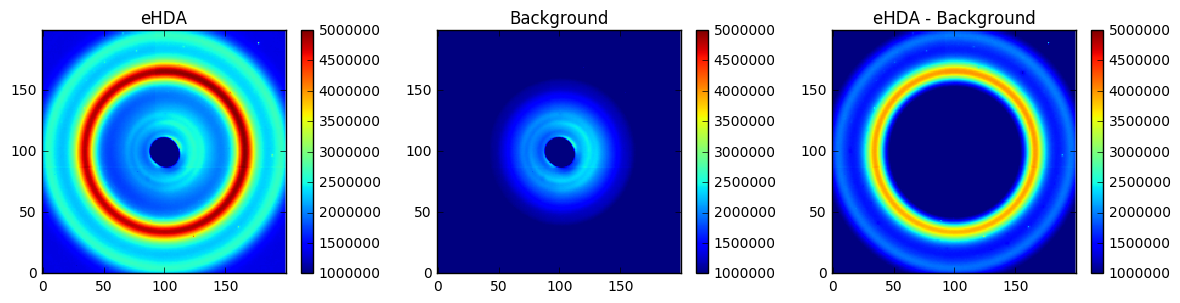

In [18]:
# plots
dx,dy = 100,100

plt.figure(figsize=[12,3])
plt.subplot(1,3,1)
vmin,vmax = 1e6,5*1e6
plt.imshow(ehda[cx-dx:cx+dx,cy-dy:cy+dy],origin='lower',interpolation='none',vmax =vmax,vmin=vmin)
plt.colorbar()
plt.title('eHDA')

plt.subplot(1,3,2)
plt.imshow(background[cx-dx:cx+dx,cy-dy:cy+dy],origin='lower',interpolation='none',vmax =vmax,vmin=vmin)
plt.colorbar()
plt.title('Background')

plt.subplot(1,3,3)
plt.imshow(ehda2[cx-dx:cx+dx,cy-dy:cy+dy],origin='lower',interpolation='none',vmax =vmax,vmin=vmin)
plt.colorbar()
plt.title('eHDA - Background')

plt.tight_layout()
plt.show()


Angular integration and Q-calibration (use the CeO2 for more precise q calibration)

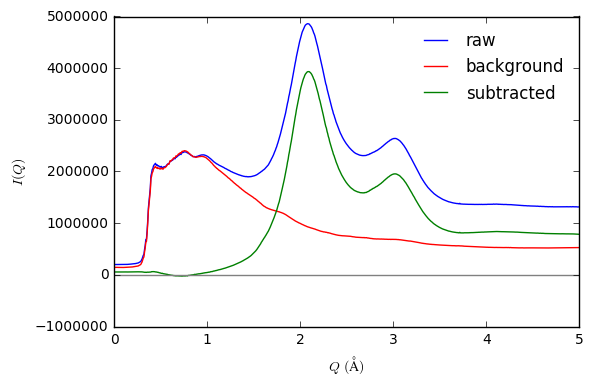

In [19]:
# angular intergation
qbin,Iq0 = angular_average(ehda, (cx,cy),None,threshold=mask_thr, nx=n_bins,  min_x=min_x, max_x=max_x)
qbin,Iq1 = angular_average(background*norm, (cx,cy),None,threshold=mask_thr, nx=n_bins,  min_x=min_x, max_x=max_x)
qbin,Iq2 = angular_average(ehda2, (cx,cy),None,threshold=mask_thr, nx=n_bins,  min_x=min_x, max_x=max_x)

# plot for comparison
plt.figure()
plt.plot(q,Iq0,'b-',label='raw')
plt.plot(q,Iq1,'r-',label='background')
plt.plot(q,Iq2,'g-',label='subtracted')
plt.axhline(y=0,c='gray')
plt.ylabel(r'$I(Q)$')
plt.xlabel(r'$Q$ $\rm(\AA)$')
plt.xlim([0,5])
plt.legend(frameon=False)
plt.show()

### Polarization correction

Nota that the polarization corection pol_cor is preety slow. So when running a loop with mupltiple datasets this can be prefromed once. 

In [9]:
nx,ny = len(ehda[:,0]),len(ehda[0,:])
alpha = pol_corr((cx,cy), L, pxd, polfac, nx,ny)

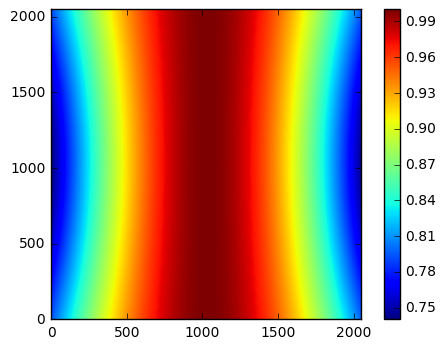

In [10]:
plt.figure()
plt.imshow(alpha,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

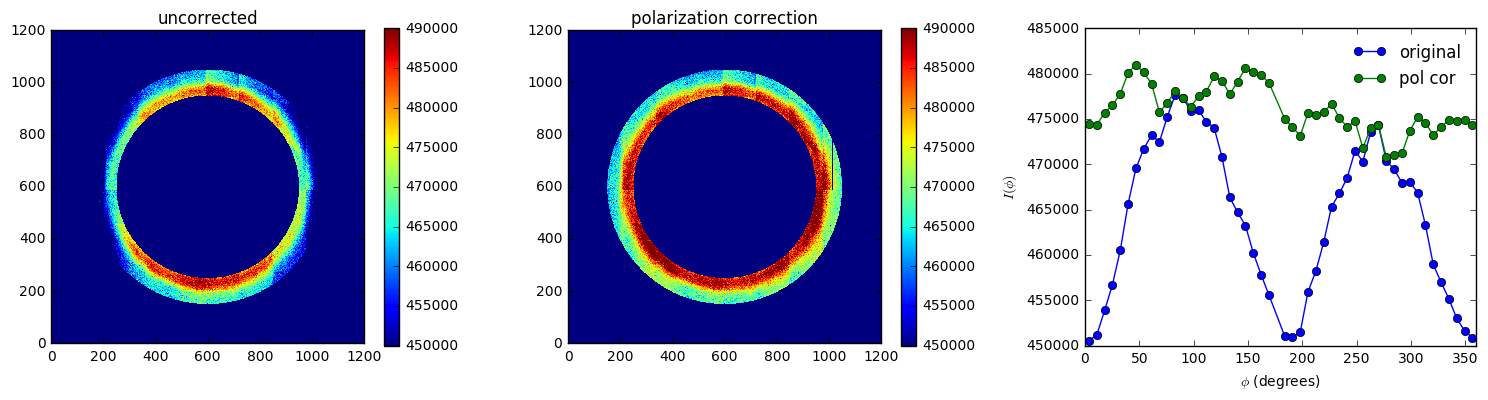

In [11]:
# parameters
inner_radius,width,spacing,num_rings=350,100,0,1
n_phi_bins,min_bin,max_bin = 50,-np.pi,np.pi
thr = 1e4

# ring mask
mask = ring_mask(ehda2,(cx,cy),inner_radius=inner_radius,width=width,spacing=spacing,num_rings=num_rings)

# radial integration
I = radial_average(ehda2,calibrated_center=(cx,cy),mask=mask,nx=n_phi_bins,min_x=min_bin,max_x=max_bin)
phi,Iphi = I[0]*180./np.pi+180.,I[1]

I = radial_average(ehda2/alpha,calibrated_center=(cx,cy),mask=mask,nx=n_phi_bins,min_x=min_bin,max_x=max_bin)
phi2,Iphi2 = I[0]*180./np.pi+180.,I[1]

# plots
dx,dy = 600,600
vmin,vmax = 4.5*1e5,4.9*1e5
plt.figure(figsize=[15,4])

plt.subplot(1,3,1)
plt.imshow(ehda2[cx-dx:cx+dx,cy-dy:cy+dy]*mask[cx-dx:cx+dx,cy-dy:cy+dy],origin='lower',interpolation='none',vmax =vmax,vmin=vmin)
plt.colorbar()
plt.title('uncorrected')

plt.subplot(1,3,2)
plt.imshow(ehda2[cx-dx:cx+dx,cy-dy:cy+dy]*mask[cx-dx:cx+dx,cy-dy:cy+dy]/alpha[cx-dx:cx+dx,cy-dy:cy+dy],origin='lower',interpolation='none',vmax =vmax,vmin=vmin)
plt.colorbar()
plt.title('polarization correction')

plt.subplot(1,3,3)
plt.plot(phi[Iphi>thr],Iphi[Iphi>thr],'bo-',label='original')
plt.plot(phi2[Iphi2>thr],Iphi2[Iphi2>thr],'go-',label='pol cor')
plt.xlim([0,360])
plt.ylabel(r'$I(\phi)$')
plt.xlabel(r'$\phi$ (degrees)')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### Solid angle correction 

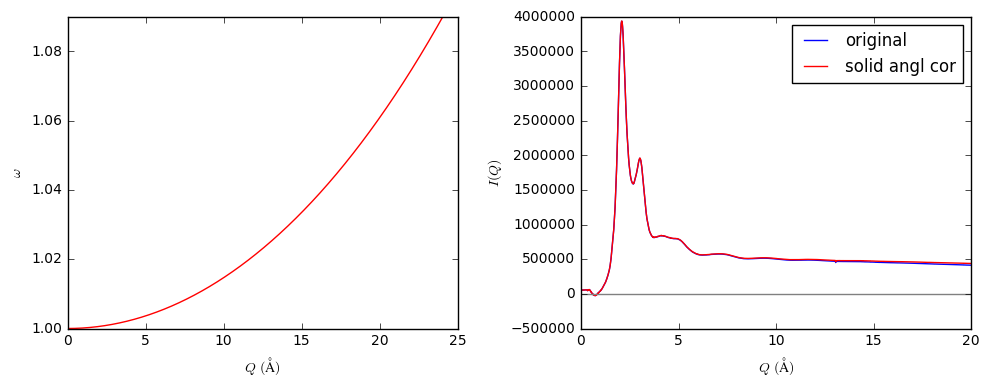

In [25]:
omega = SolAng_corr(q, pxd,  wlen, L)
qbin,Iq = angular_average(ehda2/alpha, (cx,cy),None,threshold=mask_thr, nx=n_bins,  min_x=min_x, max_x=max_x)

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(q,1./omega,'r-',label='solid angl cor')
plt.ylabel(r'$\omega$')
plt.xlabel(r'$Q$ $\rm(\AA)$')

plt.subplot(1,2,2)
plt.plot(q,Iq,'b-',label='original')
plt.plot(q,Iq/omega,'r-',label='solid angl cor')
plt.axhline(y=0,c='gray')
plt.ylabel(r'$I(Q)$')
plt.xlabel(r'$Q$ $\rm(\AA)$')
plt.xlim([0,20])
plt.legend()
plt.tight_layout()
plt.show()